Neural parameter inference for the SIRS model of infection
---
In this notebook we learn constant and non-constant parameters from (noisy) observations of the S-I-R-S model; similar to the SIR model, three comparments of susceptible, infected, and recovered agents interact via
$$S \overset{k_I}{\longrightarrow} I \overset{k_R}{\longrightarrow} R \overset{k_S}{\longrightarrow} S.$$
Unlike the standard SIR model, agents can lose their immunity and move back into the 'Susceptible' compartment with probability $k_S$. The system of ODEs thus reads:
$$ \begin{gather} \partial_t S = -k_I SI + k_S R \\ \partial_t I = k_I SI - k_R I \\ \partial_t R = k_R I - k_S R \end{gather}$$

In [1]:
import torch
import tqdm

# Plotting
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches

# Local imports
from model import SIRS_euler, SIRS_dopri5, SIRS_rk4_adj, SIRS_euler_t
from include import neural_net
from model_plots.data_ops import joint_2D_ds, marginal_from_joint

# Use a custom style sheet
plt.style.use('../../plot_style.mplstyle')
%matplotlib inline

First, let's generate some synthetic observation data. We provide a number of different numerical solvers in the `model.py` file which all use the same interface:

[Text(0.5, 1.0, 'Runge-Kutta 4 solver')]

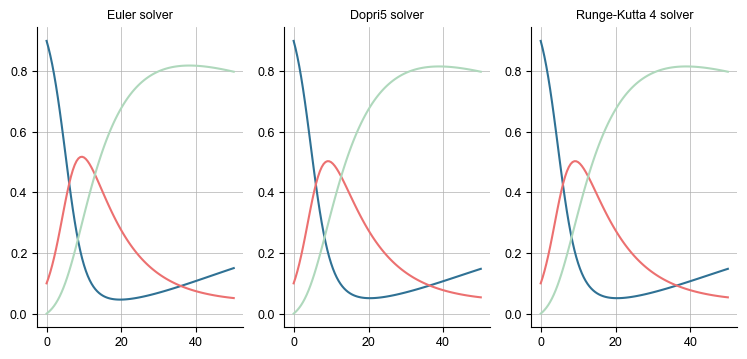

In [2]:
# Initial condition
y0 = torch.tensor([0.9, 0.1, 0.0])

# Time span and differential
t_span = (0.0, 50.0)
dt = 0.5

# The numerical solvers return grid of time points and associated y-values
fig, axs = plt.subplots(ncols=3)
axs[0].plot(*SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_S=0.01, k_I=0.5, k_R=0.1))
axs[0].set(title='Euler solver')

axs[1].plot(*SIRS_dopri5(y0=y0, t_span=t_span, dt=dt, k_S=0.01, k_I=0.5, k_R=0.1))
axs[1].set(title='Dopri5 solver')

axs[2].plot(*SIRS_rk4_adj(y0=y0, t_span=t_span, dt=dt, k_S=0.01, k_I=0.5, k_R=0.1))
axs[2].set(title='Runge-Kutta 4 solver')

## 1. Learn constant parameters from a single time series
Let's generate some noisy, synthetic data using the Euler solver. The noise is multiplicative noise, meaning we perturb all values by 5\%. We'll store everything in a single dictionary for later reference.

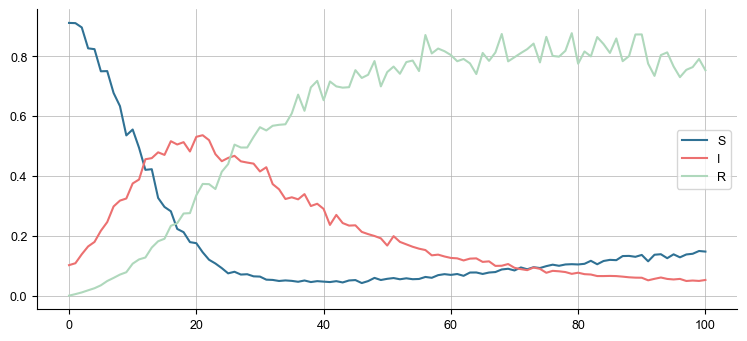

In [3]:
# Example using constant parameters
const_data = dict(true_params=dict(k_I=0.5, k_R=0.1, k_S=0.01))

# Generate some synthetic, noisy data
t, Y = SIRS_euler(y0=y0, t_span=t_span, dt=dt, **const_data['true_params'])
Y = torch.normal(Y, 0.05 * Y)

# Store the observation data
const_data['t'] = t
const_data['Y'] = Y
const_data['Y_train'] = Y
const_data['X_train'] = Y.flatten()

# Plot the observation data
plt.plot(Y, label=['S', 'I', 'R'])
plt.legend()

Now let's initialise a simple feed-forward network to learn the parameters:

In [4]:
const_data['NN'] = neural_net.FeedForwardNN(
    input_size = const_data['X_train'].shape[0], # Input entire time series
    output_size = 3, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training loss and parameter estimates
const_data.update(dict(loss=[], param_ests=[]))

Training the network for 200 epochs to learn the parameters should take about 1-5 seconds on a regular laptop:

In [5]:
N_epochs = 200
for i in (pbar := tqdm.trange(N_epochs)):

    # Make a prediction from the time series
    pred = const_data['NN'](const_data['X_train'])

    # Generate a time series
    _, Y_pred = SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_I = pred[0], k_R=pred[1], k_S=pred[2])

    # Calculate the loss
    loss = torch.nn.functional.mse_loss(Y_pred, const_data['Y_train'])
    loss.backward()
    const_data['NN'].optimizer.step()
    const_data['NN'].optimizer.zero_grad()
    const_data['loss'].append(loss.detach())
    const_data['param_ests'].append(pred.detach())
    pbar.set_description(f"Loss: {loss:>.4g}")

Loss: 0.0003793: 100%|██████████| 200/200 [00:01<00:00, 123.99it/s]


Once trained, we can use the network to make a parameter prediction, plug these into the ODE, and visualise the result:

[None, Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss $J$')]

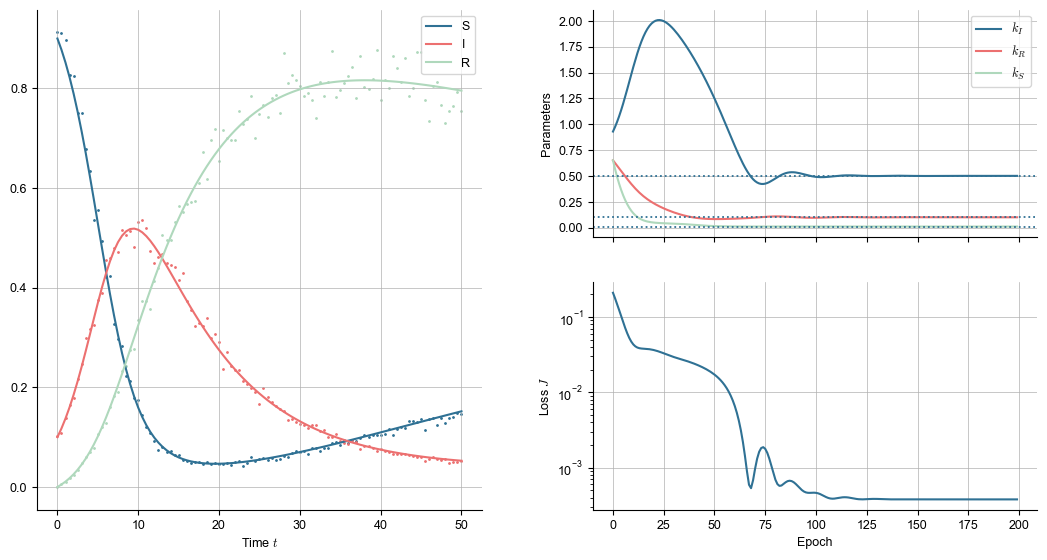

In [6]:
pred = const_data['NN'](const_data['X_train']).detach()
_, Y_pred = SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_I = pred[0], k_R=pred[1], k_S=pred[2])


# Plot the data and prediction
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, wspace=0.25)
ax1 = fig.add_subplot(gs[0:2, 0])
for i, label in enumerate(['S', 'I', 'R']):
    _s = ax1.scatter(const_data['t'], const_data['Y'][:, i], s=1)
    _l = ax1.plot(const_data['t'], Y_pred[:, i], label=label)
ax1.legend()
ax1.set(xlabel='Time $t$')

# Plot the parameter estimates
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(torch.stack(const_data['param_ests'])[:, 0], label='$k_I$')
ax2.plot(torch.stack(const_data['param_ests'])[:, 1], label='$k_R$')
ax2.plot(torch.stack(const_data['param_ests'])[:, 2], label='$k_S$')

ax2.legend()
ax2.axhline(const_data['true_params']['k_I'], ls='dotted', lw=1.3)
ax2.axhline(const_data['true_params']['k_R'], ls='dotted', lw=1.3)
ax2.axhline(const_data['true_params']['k_S'], ls='dotted', lw=1.3)

ax2.set(ylabel='Parameters')
plt.setp(ax2.get_xticklabels(), visible=False)

# Plot the loss
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)
ax3.plot(const_data['loss'])
ax3.set(yscale='log', xlabel='Epoch', ylabel='Loss $J$')

### Train on an ensemble of constant parameters
This is nice but boring — we could have just used an optimiser. What if we have an ensemble of datasets, and wish to learn the constants for each: how well can we extrapolate to new data? To this end, let us generate an ensemble of 4 training datasets and 2 (unseen) test sets:

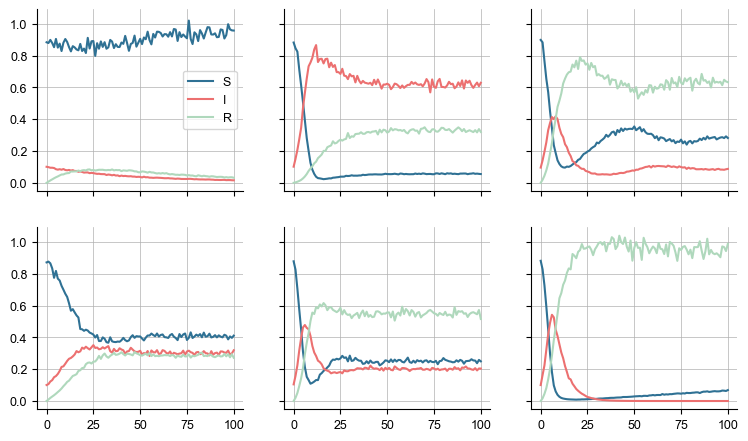

In [7]:
# Generate an ensemble of datasets
n_ensemble = 6
n_train = 4
ensemble_data = dict(true_params=[dict(k_I=2*torch.rand(1).squeeze(), k_R=0.5*torch.rand(1).squeeze(), k_S=0.2*torch.rand(1).squeeze()) for _ in range(n_ensemble)])

# Generate training data. We store everything in a dictionary unique to our specific example.
ensemble_data['data']= [dict(Y=SIRS_euler(y0=y0, t_span=t_span, dt=dt, **p)[1]) for p in ensemble_data['true_params']]
ensemble_data['t']=SIRS_euler(y0=y0, t_span=t_span, dt=dt, **const_data['true_params'])[0]

# Add noise to the training data
for idx, d in enumerate(ensemble_data['data']):
    ensemble_data['data'][idx]['Y'] = torch.normal(d['Y'], 0.03*d['Y'])
fig, axs = plt.subplots(figsize=(7, 4), ncols=3, nrows=2, sharex=True, sharey=True)
for idx, _d in enumerate(ensemble_data['data']):
    axs.flatten()[idx].plot(_d['Y'], label=['S', 'I', 'R'])
axs.flatten()[0].legend()

We again train the neural network to learn the constant parameters from each dataset in the training set:

In [8]:
for _d in ensemble_data['data']:
    _d.update(dict(X_train = _d['Y'].flatten(), Y_train = _d['Y']))

ensemble_data.update(dict(NN=neural_net.FeedForwardNN(
    input_size = ensemble_data['data'][0]['X_train'].shape[0], # Input entire time series
    output_size = 3, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)))

# Store the training loss and parameter estimates
ensemble_data.update(dict(loss=[], param_ests=[]))

Let's the train the network for a bit longer this time:

In [9]:
N_epochs = 1000
for i in (pbar := tqdm.trange(N_epochs)):

    loss = torch.tensor(0.0)
    for ds in ensemble_data['data'][:n_train]:

        # Make a prediction from the time series
        pred = ensemble_data['NN'](ds['X_train'])

        # Generate a time series
        _, Y_pred = SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_I = pred[0], k_R=pred[1], k_S=pred[2])

        # Calculate the loss
        loss = loss + torch.nn.functional.mse_loss(Y_pred, ds['Y_train'])

    loss.backward()
    ensemble_data['NN'].optimizer.step()
    ensemble_data['NN'].optimizer.zero_grad()
    ensemble_data['loss'].append(loss.detach())
    ensemble_data['param_ests'].append(pred.detach())
    pbar.set_description(f"Loss: {loss:>.4g}")

Loss: 0.0008853: 100%|██████████| 1000/1000 [00:28<00:00, 35.63it/s]


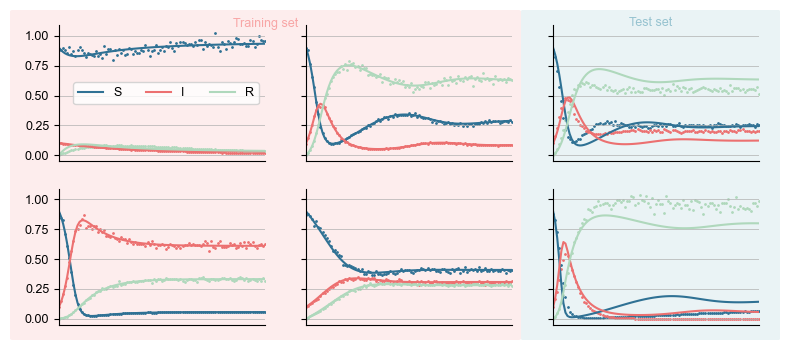

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True)

for idx, _d in enumerate(ensemble_data['data']):

    # Plot the true data
    for j in range(3):
        axs.transpose(1, 0).flatten()[idx].scatter(ensemble_data['t'], _d['Y'][:, j], s=1)

    # Make a prediction from the time series
    pred = ensemble_data['NN'](_d['X_train']).detach()
    axs.transpose(1, 0).flatten()[idx].plot(*SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_I = pred[0], k_R=pred[1], k_S=pred[2]), label=['S', 'I', 'R'])
axs[0, 0].legend(ncols=3)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_xlim(*ensemble_data['t'][[0, -1]])
    ax.patch.set_alpha(0.)

# Highlight train and test periods
for (pos, label, color) in [([-0.07, -0.05, 0.73, 1.1], 'Training set', 'C9'), ([0.66, -0.05, 0.37, 1.1], 'Test set', 'C5')]:
    box = fig.add_axes(pos, zorder=-2)
    box.axis('off')
    rect = patches.FancyBboxPatch((0, 0), 1, 1, linewidth=0, facecolor=color, alpha=0.2, transform=box.transAxes, boxstyle='Round, pad=0, rounding_size=0.005')
    box.add_patch(rect)
    box.text(0.5, 0.95, label, color=color, ha='center')
    fig.add_axes(box)

The results are good on the training data and reasonable – but not amazing — on the test data: not surprising, as a training set size of four is very small. As we increase the training data, the accuracy on the test data will improve. This is computationally best done by running several sweeps in parallel using the `utopya` model:

```
utopya run SIRS --cs test_performance
```
This will generate a collection of test-train datasets and train a neural network on each to compare generalisation performance. You can also try running

```
utopya run SIRS --pp num_epochs=100
```
to produce results on 4 training sets and 2 test sets that are similar to the above.

## 2. Learn time-dependent parameters
### Seasonal SIRS model
Next, let us learn time-dependent parameter functions. In a first example, we let the parameters be a function of some external forcing, e.g. temperature. The parameters are now implicit functions of time. We train the neural network on one cycle of the parameters, and see if can learn the correct pattern.

[Text(0.5, 1.0, 'SIRS data')]

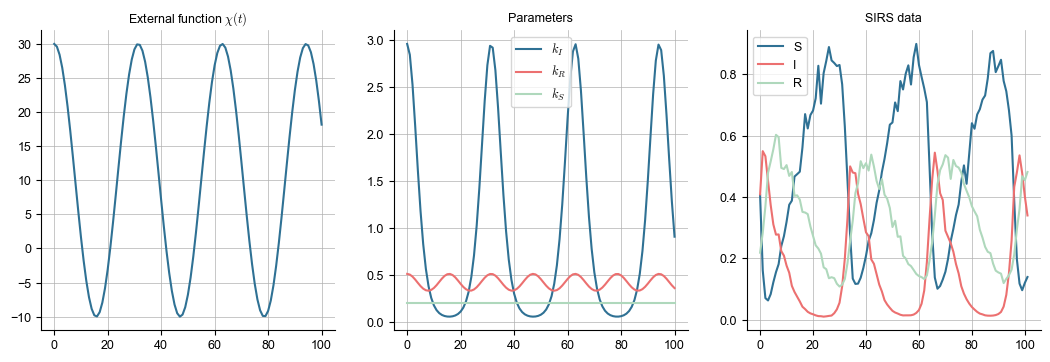

In [36]:
# Make parameters a function of the external temperature
temp = 20*torch.cos(0.2*torch.arange(0, 101, 1))+10

# Parameters are some arbitrary function of the temperature
seasonal_params=dict(k_I=0.4*torch.exp(0.1*(temp-10)),
                     k_R=0.33*torch.cosh(0.05*(temp-10)),
                     k_S=0.2*torch.cosh(0.*(temp-10)))

# Generate noisy data using the SIRS_euler_t solver -- this allows using time-dependent parameters
seasonal_data=dict(X=SIRS_euler_t(y0=y0, t_span=t_span, dt=dt, **seasonal_params)[1])
seasonal_data=dict(X=SIRS_euler_t(y0=seasonal_data['X'][-6], t_span=t_span, dt=dt, **seasonal_params)[1])
seasonal_data['X'] = torch.normal(seasonal_data['X'], 0.05*seasonal_data['X'])

# Plot external function, parameters, and SIRS data
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
axs[0].plot(temp)
axs[1].plot(seasonal_params['k_I'], label='$k_I$')
axs[1].plot(seasonal_params['k_R'], label='$k_R$')
axs[1].plot(seasonal_params['k_S'], label='$k_S$')
axs[1].legend()
axs[2].plot(seasonal_data['X'], label=['S', 'I', 'R'])
axs[2].legend()

axs[0].set(title='External function $\chi(t)$')
axs[1].set(title='Parameters')
axs[2].set(title='SIRS data')

In [59]:
# Train on a portion of the data
L = len(seasonal_data['X']) // 3
seasonal_data.update(dict(X_train=temp[:L].reshape(-1, 1), Y_train=seasonal_data['X'][:L]))

# Initialise the neural network
seasonal_data['NN'] = neural_net.FeedForwardNN(
    input_size = 1, # Temperature
    output_size = 3, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training data
seasonal_data['loss'] = []

In [65]:
# Train
for i in (pbar := tqdm.trange(6000)):

    # Make a prediction
    pred = seasonal_data['NN'](seasonal_data['X_train'])

    # Generate a time series
    Y_pred = SIRS_euler_t(y0=seasonal_data['Y_train'][0], t=torch.arange(0, (L-1)*dt, dt), dt=dt, k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2])[1]

    # Calculate gradient of loss
    loss = torch.nn.functional.mse_loss(Y_pred, seasonal_data['Y_train'])
    loss.backward()

    # Step
    seasonal_data['NN'].optimizer.step()
    seasonal_data['NN'].optimizer.zero_grad()

    seasonal_data['loss'].append(loss.detach())
    pbar.set_description(f"Loss: {loss.detach():>.5g}")

Loss: 0.00062154: 100%|██████████| 6000/6000 [00:17<00:00, 338.09it/s]


Text(0.7, 0.8, 'Predict')

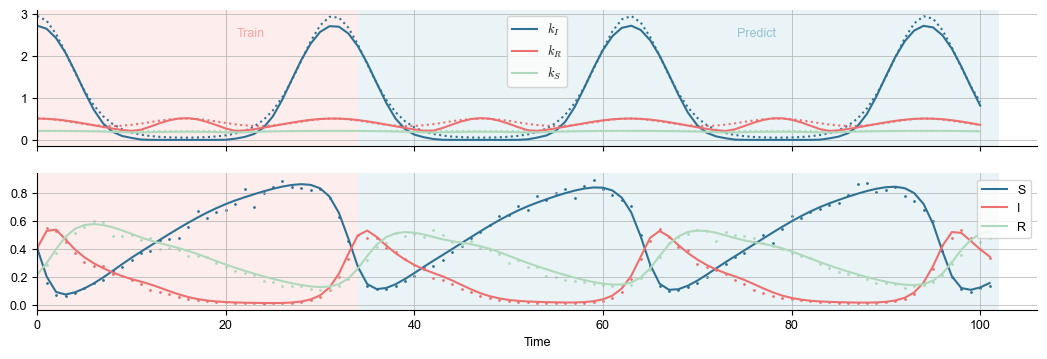

In [73]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True)

pred = seasonal_data['NN'](temp.reshape(-1, 1)).detach()
X_pred = SIRS_euler_t(y0=seasonal_data['Y_train'][0], t_span=t_span, dt=dt, k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2])[1]
axs[0].plot(seasonal_params['k_I'], c='C0', ls='dotted')
axs[0].plot(seasonal_params['k_R'], c='C1', ls='dotted')
axs[0].plot(seasonal_params['k_S'], c='C2', ls='dotted')
axs[1].plot(X_pred, label=['S', 'I', 'R'])
for i, label in enumerate(['$k_I$', '$k_R$', '$k_S$']):
    axs[0].plot(pred[:, i], c=f'C{i}', label=label)
    axs[1].scatter(torch.arange(len(seasonal_data['X'])), seasonal_data['X'][:, i], s=1)
for ax in axs:
    ax.set(xlim=(0, None))
    ax.axvspan(0, len(seasonal_data['X_train']), color='C9', alpha=0.2, zorder=-2, lw=0)
    ax.axvspan(len(seasonal_data['X_train']), len(seasonal_data['X']), color='C5', alpha=0.2, zorder=-2, lw=0)
axs[0].legend()
axs[1].legend()
axs[1].set(xlabel='Time')
axs[0].text(0.2, 0.8, 'Train', c='C9', transform=axs[0].transAxes, zorder=3)
axs[0].text(0.7, 0.8, 'Predict', c='C5', transform=axs[0].transAxes, zorder=3)

## Seasonal SIRS with time-dependent parameters
Now we let the infection and recovery rates also be explicit functions of time, e.g. using a decay rate. For this, we use a recurrent neural network.

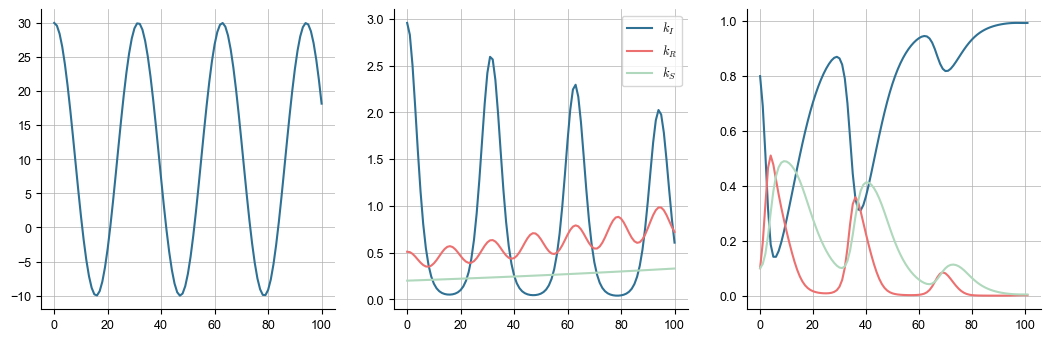

In [219]:
# Parameters are some arbitrary function of the temperature
import copy
seasonal_params_rnn=copy.deepcopy(seasonal_params)
seasonal_params_rnn['k_I'] *= torch.exp(-0.004*torch.arange(len(temp)))
seasonal_params_rnn['k_R'] *= torch.exp(0.007*torch.arange(len(temp)))
seasonal_params_rnn['k_S'] *= torch.exp(0.005*torch.arange(len(temp)))

seasonal_data_rnn=dict(X=SIRS_euler_t(y0=torch.tensor([0.8, 0.1, 0.1]), t_span=t_span, dt=dt, **seasonal_params_rnn)[1])

fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

axs[0].plot(temp)
axs[1].plot(seasonal_params_rnn['k_I'], label='$k_I$')
axs[1].plot(seasonal_params_rnn['k_R'], label='$k_R$')
axs[1].plot(seasonal_params_rnn['k_S'], label='$k_S$')
axs[1].legend()

axs[2].plot(seasonal_data_rnn['X'])

We learn the parameters using a recurrent neural network with a single hidden dimension (the time). This time, we train on two cycles.

In [220]:
class RNN(neural_net.BaseNN):

    def __init__(
        self,
        *,
        input_size: int,
        output_size: int,
        latent_dim: int,
        num_layers: int,
        nodes_per_layer: dict,
        activation_funcs: dict,
        biases: dict,
        initial_latent_state: torch.Tensor = None,
        optimizer: str = "Adam",
        learning_rate: float = 0.002,
        optimizer_kwargs: dict = {},
        **__,
    ):
        """ Recurrent neural network with an z-dimensional latent dimension

        :param input_size: the number of input values
        :param output_size: the number of output values
        :param latent_dim: latent dimension
        :param num_layers: the number of hidden layers
        :param nodes_per_layer: a dictionary specifying the number of nodes per layer
        :param activation_funcs: a dictionary specifying the activation functions to use
        :param biases: a dictionary containing the initialisation parameters for the bias
        :param optimizer: the name of the optimizer to use. Default is the torch.optim.Adam optimizer.
        :param learning_rate: the learning rate of the optimizer. Default is 1e-3.
        :param __: Additional model parameters (ignored)
        """

        super().__init__(input_size=input_size + latent_dim,
                         output_size=output_size + latent_dim,
                         num_layers=num_layers,
                         nodes_per_layer=nodes_per_layer,
                         activation_funcs=activation_funcs,
                         biases=biases,
                         optimizer=optimizer,
                         learning_rate=learning_rate,
                         optimizer_kwargs=optimizer_kwargs)
        self.latent_dim = latent_dim
        self.z = initial_latent_state if initial_latent_state is not None else torch.zeros(latent_dim)
        self.z_0 = self.z.clone()

    # ... Evaluation functions .........................................................................................

    # The model forward pass
    # TODO: improve this using torch.nn.GRU
    def forward(self, x, z = None):

        if x.dim() == 1:
            return torch.stack([self.forward(_x, z) for _x in x])

        else:
            if z is None:
                z = self.z
            x = torch.cat((x, z)) if x.dim() == 1 else torch.cat((x.unsqueeze(0), z))
            for i in range(len(self.layers)):
                if self.activation_funcs[i] is None:
                    x = self.layers[i](x)
                else:
                    x = self.activation_funcs[i](self.layers[i](x))
            self.z = x[-self.latent_dim:]
            return x[:-self.latent_dim]

    def reset_hidden_state(self, z = None):
        self.z = self.z_0.clone() if z is None else z.clone()

In [232]:
# Train on half the data
L_2 = 2*len(seasonal_data['X']) // 3
seasonal_data_rnn.update(dict(X_train=temp[:L_2], Y_train=seasonal_data_rnn['X'][:L_2]))

# Initialise the neural network
seasonal_data_rnn['NN'] = RNN(
    input_size = 1, # Temperature
    output_size = 3, # Number of parameters
    latent_dim = 1,
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training data
seasonal_data_rnn['loss'] = []

In [235]:
# Train
for i in (pbar := tqdm.trange(1000)):

    # Make a prediction
    pred = seasonal_data_rnn['NN'](seasonal_data_rnn['X_train'])

    # Generate a time series
    Y_pred = SIRS_euler_t(y0=seasonal_data_rnn['Y_train'][0], t=torch.arange(0, (L_2-1)*dt, dt), dt=dt, k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2])[1]

    # Calculate gradient of loss
    loss = torch.nn.functional.mse_loss(Y_pred, seasonal_data_rnn['Y_train'])
    loss.backward()

    # Step
    seasonal_data_rnn['NN'].optimizer.step()
    seasonal_data_rnn['NN'].optimizer.zero_grad()

    seasonal_data_rnn['loss'].append(loss.detach())

    # Need to reset the internally updated hidden state
    seasonal_data_rnn['NN'].reset_hidden_state()
    pbar.set_description(f"Loss: {loss.detach():>.5g}")

Loss: 0.0015708: 100%|██████████| 1000/1000 [00:08<00:00, 115.64it/s]


Text(0.75, 0.8, 'Predict')

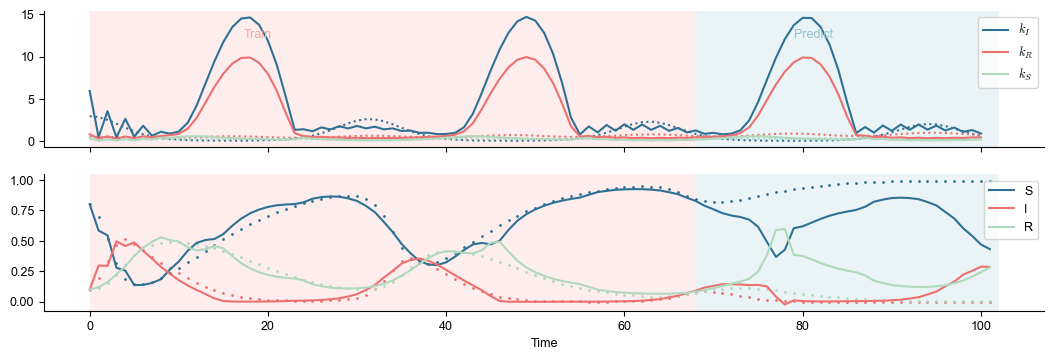

In [236]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True)

# Make a recurrent prediction
# Make a prediction
pred = seasonal_data_rnn['NN'](temp).detach()

# Generate a time series
X_pred = SIRS_euler_t(y0=seasonal_data_rnn['Y_train'][0], t_span=t_span, dt=dt, k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2])[1]

axs[0].plot(seasonal_params_rnn['k_I'], ls='dotted')
axs[0].plot(seasonal_params_rnn['k_R'], ls='dotted')
axs[0].plot(seasonal_params_rnn['k_S'], ls='dotted')
axs[1].plot(X_pred, label=['S', 'I', 'R'])
for i, label in enumerate(['$k_I$', '$k_R$', '$k_S$']):
    axs[0].plot(pred[:, i], c=f'C{i}', label=label)
    axs[1].scatter(torch.arange(len(seasonal_data_rnn['X'])), seasonal_data_rnn['X'][:, i], s=1)

for ax in axs:
    ax.axvspan(0, len(seasonal_data_rnn['X_train']), color='C9', alpha=0.2, zorder=-2, lw=0)
    ax.axvspan(len(seasonal_data_rnn['X_train']), len(seasonal_data_rnn['X']), color='C5', alpha=0.2, zorder=-2, lw=0)
    ax.grid()
    ax.legend()
axs[1].set(xlabel='Time')
axs[0].text(0.2, 0.8, 'Train', c='C9', transform=axs[0].transAxes, zorder=3)
axs[0].text(0.75, 0.8, 'Predict', c='C5', transform=axs[0].transAxes, zorder=3)

## Ensemble training
Let us again return to the case of a single, noisy SIR timeseries. Let us assume that $k_S=0$, and generate a noisy time series:

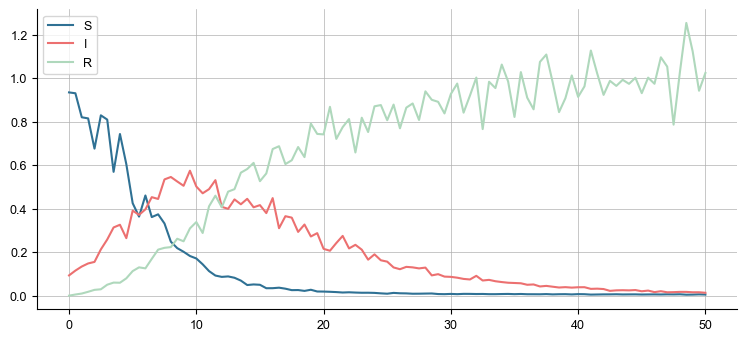

In [453]:
# Example using constant parameters
const_data = dict(true_params=dict(k_I=0.5, k_R=0.1, k_S=0.0))

# Generate some synthetic, noisy data
t, Y = SIRS_euler(y0=y0, t_span=t_span, dt=dt, **const_data['true_params'])
Y = torch.normal(Y, 0.1 * Y)

# Store the observation data
const_data['t'] = t
const_data['Y'] = Y
const_data['Y_train'] = Y
const_data['X_train'] = Y.flatten()

# Plot the observation data
#plt.plot(*SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_I=0.6, k_R=0.1, k_S=0))
plt.plot(t, Y, label=['S', 'I', 'R'])
plt.legend()

Let's look at the ground truth distribution by performing a grid search over $k_I$ and $k_R$:

In [454]:
# Generate the ground truth distribution (takes around 10sec to generate)
vals = []
k_R_vals = torch.linspace(0.01, 0.3, 50)
k_I_vals = torch.linspace(0.1, 1, 50)
for k_R in k_R_vals:
    v = []
    for k_I in k_I_vals:
        _Y = SIRS_euler(y0=y0, t=t, k_I=k_I, k_R=k_R, k_S=0.0)[1]
        v.append(torch.nn.functional.mse_loss(_Y, Y))
    vals.append(torch.stack(v))
vals = torch.stack(vals)

In [459]:
# Train an ensemble of 10 neural networks
NN_ensemble = [neural_net.FeedForwardNN(
    input_size = const_data['X_train'].shape[0], # Input entire time series
    output_size = 2, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
) for _ in range(20)]

# Store the training loss and parameter estimates
ensemble_ests = [dict(loss=[], param_ests=[]) for _ in range(len(NN_ensemble))]

# Train for 200 epochs. This takes around 30 secs.
N_epochs = 200
for idx in tqdm.trange(len(NN_ensemble)):
    for i in range(N_epochs):

        # Make a prediction from the time series
        pred = NN_ensemble[idx](const_data['X_train'])

        # Generate a time series
        _, Y_pred = SIRS_euler(y0=y0, t_span=t_span, dt=dt, k_I = pred[0], k_R=pred[1], k_S=0.0)

        # Calculate the loss
        loss = torch.nn.functional.mse_loss(Y_pred, const_data['Y_train'])
        loss.backward()
        NN_ensemble[idx].optimizer.step()
        NN_ensemble[idx].optimizer.zero_grad()
        ensemble_ests[idx]['loss'].append(loss.detach())
        ensemble_ests[idx]['param_ests'].append(pred.detach())

Let's compare the ground truth distribution and the joint estimated from the weighted sample style distribution

In [536]:
loss_ts_xr = xr.DataArray(data=torch.concat([torch.stack(e['loss']) for e in ensemble_ests]), dims=["batch"])
parameters_ts_xr = xr.DataArray(
    data=torch.concat([torch.stack(e['param_ests']) for e in ensemble_ests]),
    dims=["batch", "parameter"],
    coords={"parameter": ["k_I", "k_R"]}
)
joint = joint_2D_ds(parameters_ts_xr, loss_ts_xr, x="k_I", y="k_R", bins=200)

[(0.10000000149011612, 1.0), (0.009999999776482582, 0.30000001192092896)]

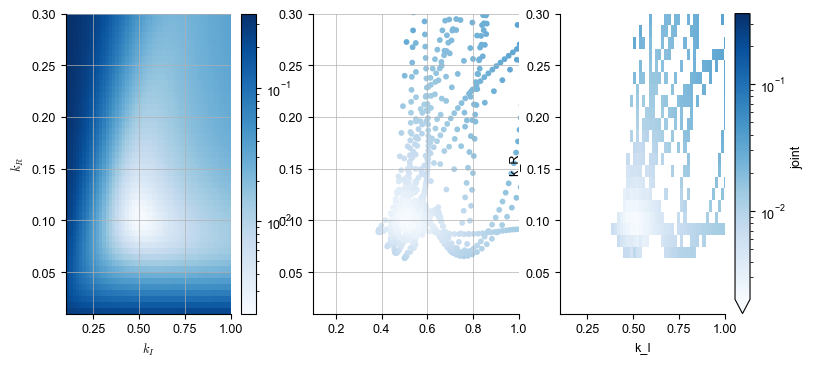

In [537]:
fig, axs = plt.subplots(ncols=3)
im = axs[0].imshow(vals, extent=[*k_I_vals[[0, -1]], *k_R_vals[[0, -1]]], norm='log', origin='lower', aspect='auto', cmap='Blues', vmin=vals.min(), vmax=vals.max())
axs[0].set(xlabel='$k_I$', ylabel='$k_R$')

for idx in range(len(ensemble_ests)):
    axs[1].scatter(*torch.stack(ensemble_ests[idx]['param_ests']).transpose(0, 1), c=ensemble_ests[idx]['loss'], norm='log', cmap='Blues', s=10, vmin=vals.min(), vmax=vals.max())
axs[1].set(xlim=axs[0].get_xlim(), ylim=axs[0].get_ylim())
fig.colorbar(im)
joint.plot.pcolormesh(ax=axs[2], x='k_I', y='k_R', cmap='Blues', norm=matplotlib.colors.LogNorm(vmin=vals.min(), vmax=vals.max()))
axs[2].set(xlim=axs[0].get_xlim(), ylim=axs[0].get_ylim())

We can compare the marginals:

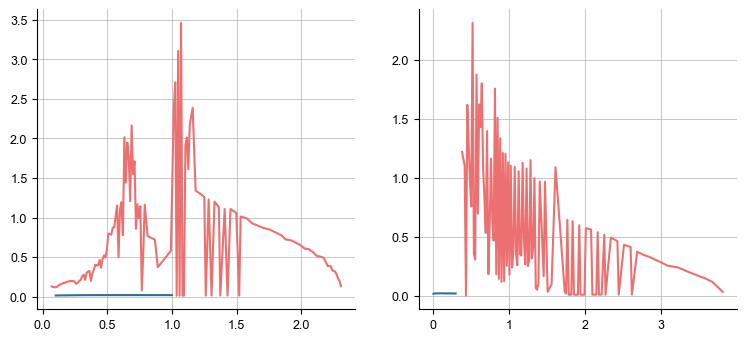

In [552]:
fig, axs = plt.subplots(ncols=2)
axs[0].plot(k_I_vals, torch.exp(-vals).sum(dim=0)/torch.exp(-vals).sum())
axs[1].plot(k_R_vals, torch.exp(-vals).sum(dim=1)/torch.exp(-vals).sum())

marg_1 = marginal_from_joint(joint, parameter='k_R')
axs[0].plot(marg_1.x[marg_1.y>0], marg_1.y[marg_1.y>0])

marg_2 = marginal_from_joint(joint, parameter='k_I')
axs[1].plot(marg_2.x[marg_2.y>0], marg_2.y[marg_2.y>0])

This is nice, but could be made computationally more efficient by training the ensemble in parallel. This is what the `utopya` version of this model is for, which wraps the above model and can easily be called using the ```utopya run SIRS``` command. Take a look at the `README` for futher details, or try calling ```utopya run SIRS --cs SIR_example``` to re-run the above ensemble training example in parallel.